In [37]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tabulate import tabulate

from pyfdm.graphs import *
from pyfdm import methods
from pyfdm.TFN import TFN
from pyfdm.methods import utils
from pyfdm import weights as f_weights
from pyfdm import correlations as corrs
from pyfdm.helpers import rank, generate_fuzzy_matrix

np.set_printoptions(suppress=True, precision=3)

In [20]:
f_methods = {
    'fARAS': methods.fARAS(),
    'fCODAS': methods.fCODAS(),
    'fCOPRAS': methods.fCOPRAS(),
    'fEDAS': methods.fEDAS(),
    'fMABAC': methods.fMABAC(),
    'fMAIRCA': methods.fMAIRCA(),
    'fMOORA': methods.fMOORA(),
    'fOCRA': methods.fOCRA(),
    'fTOPSIS': methods.fTOPSIS(),
    'fVIKOR': methods.fVIKOR()
}

# EXAMPLE 1

Chen, C. T. (2000). Extensions of the TOPSIS for group decision-making under fuzzy environment. Fuzzy sets and systems, 114(1), 1-9.

In [21]:
matrix = np.array([
    [[3, 4, 5],[4, 5, 6],[8, 9, 9]],
    [[6, 7, 8],[4, 5, 6],[1, 2, 3]],
    [[5, 6, 7],[2, 3, 4],[3, 4, 5]],
    [[8, 9, 9],[2, 3, 4],[2, 3, 4]],
    [[7, 8, 9],[7, 8, 9],[5, 6, 7]],
])

weights = np.array([0.394, 0.084, 0.522])
types = np.array([-1, 1, 1])

In [22]:
results = []
for name, method in f_methods.items():
    if name == 'fVIKOR':
        results.append(rank(method(matrix, weights, types)[0], descending=False))
    else:
        results.append(rank(method(matrix, weights, types)))

In [23]:
print(tabulate(np.array(results).T, headers=list(f_methods.keys())))

  fARAS    fCODAS    fCOPRAS    fEDAS    fMABAC    fMAIRCA    fMOORA    fOCRA    fTOPSIS    fVIKOR
-------  --------  ---------  -------  --------  ---------  --------  -------  ---------  --------
      1         1          1        1         1          4         1        1          1         1
      4         4          4        4         4          1         4        5          5         4
      3         3          3        3         3          2         5        3          3         3
      5         5          5        5         5          3         3        4          4         5
      2         2          2        2         2          5         2        2          2         2


### HEATMAP

In [24]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(labels=col_labels, fontsize=18)
    
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(labels=row_labels, fontsize=18)


    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
             rotation_mode="anchor")


    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center",
              fontsize=24)
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


In [25]:
C = np.zeros((len(results), len(results)))
for i1, r1 in enumerate(results):
    for i2, r2 in enumerate(results):
        C[i1, i2] = np.round(corrs.ws_rank_similarity_coef(r1, r2), 2)

In [26]:
plt.rcParams['figure.figsize'] = (12, 12)

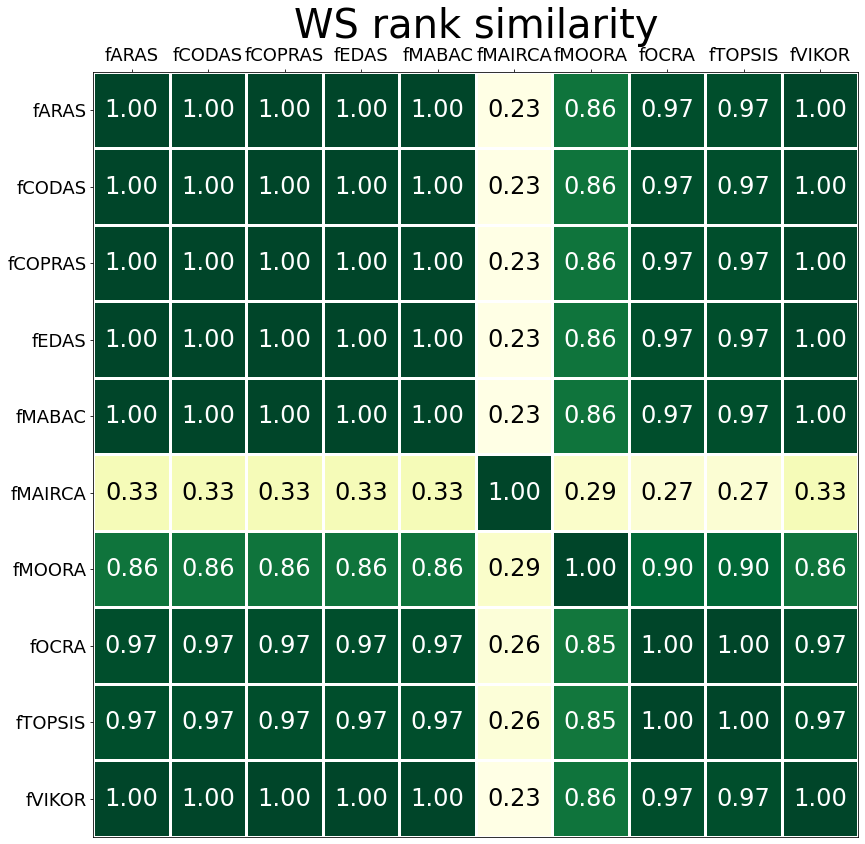

In [27]:
fig, ax = plt.subplots()

im = heatmap(C, list(f_methods.keys()), list(f_methods.keys()), ax=ax,
                   cmap="YlGn", cbarlabel="WS rank similarity")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

plt.title(f'WS rank similarity', fontsize=40)
fig.tight_layout()
plt.savefig(f'WS.png')


# EXAMPLE 2

Karande, P., & Chakraborty, S. (2012). A Fuzzy-MOORA approach for ERP system selection. Decision Science Letters, 1(1), 11-21.

In [28]:
matrix = np.array([
    [[0.6, 0.8, 1], [0.6, 0.8, 1], [0.4, 0.6, 0.8], [0.2, 0.4, 0.6], [0.8, 1, 1]],
    [[0.4, 0.6, 0.8], [0.6, 0.8, 1], [0.4, 0.6, 0.8],
        [0.8, 1, 1], [0.2, 0.4, 0.6]],
    [[0.8, 1, 1], [0.4, 0.6, 0.8], [0.6, 0.8, 1], [0, 0.2, 0.4], [0, 0.2, 0.4]],
    [[0.2, 0.4, 0.6], [0.4, 0.6, 0.8], [
        0.4, 0.6, 0.8], [0.6, 0.8, 1], [0.4, 0.6, 0.8]]
])

weights = np.array([0.364, 0.271, 0.203, 0.094, 0.068])
types = np.array([-1, 1, 1, 1, 1])

In [29]:
moora = {
    'Sum': methods.fMOORA(utils.normalizations.sum_normalization),
    'Max': methods.fMOORA(utils.normalizations.max_normalization),
    'Linear': methods.fMOORA(utils.normalizations.linear_normalization),
    'Minmax': methods.fMOORA(utils.normalizations.minmax_normalization),
    'Vector': methods.fMOORA(utils.normalizations.vector_normalization),
    'SAW': methods.fMOORA(utils.normalizations.saw_normalization)
}

In [30]:
results_pref = {}
results_rank = {}
for name, function in moora.items():
    results_pref[name] = function(matrix, weights, types)
    results_rank[name] = rank(function(matrix, weights, types))

In [31]:
print(tabulate([[name, *np.round(pref, 2)] for name, pref in results_pref.items()],
    headers=['Method'] + [f'A{i+1}' for i in range(10)]))

Method      A1    A2    A3    A4
--------  ----  ----  ----  ----
Sum       0.2   0.2   0.17  0.23
Max       0.48  0.42  0.44  0.28
Linear    0.35  0.33  0.29  0.18
Minmax    0.27  0.2   0.26  0.08
Vector    0.07  0.1   0.04  0.11
SAW       0.15  0.24  0.08  0.26


In [32]:
print(tabulate([[name, *np.round(pref, 2)] for name, pref in results_rank.items()],
    headers=['Method'] + [f'A{i+1}' for i in range(10)]))

Method      A1    A2    A3    A4
--------  ----  ----  ----  ----
Sum          3     2     4     1
Max          1     3     2     4
Linear       1     2     3     4
Minmax       1     3     2     4
Vector       3     2     4     1
SAW          3     2     4     1


### RADAR PLOT

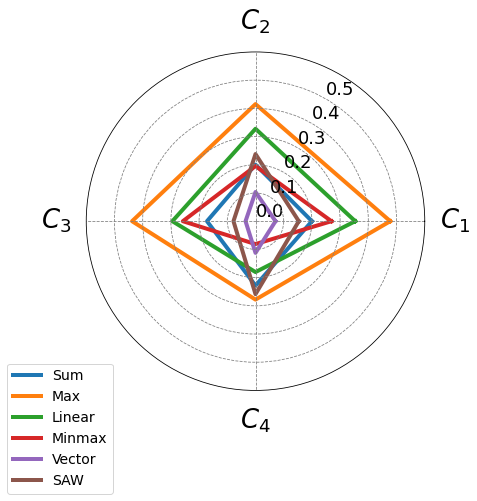

In [33]:
plt.rcParams['figure.figsize'] = (7, 7)
vis_df = pd.DataFrame(np.array(list(results_pref.values())).T, columns=['Sum', 'Max', 'Linear', 'Minmax', 'Vector', 'SAW'])

angles = [n / float(vis_df.shape[0]) * 2 *
          np.pi for n in range(vis_df.shape[0])]
angles += angles[:1]

x = [f'$C_{i+1}$' for i in range(vis_df.shape[0])]

for c in vis_df.columns:
    values = vis_df[c].values.tolist()
    values += values[:1]
    ax = plt.subplot(111, polar=True)
    XTICKS = ax.xaxis.get_major_ticks()
    for tick in XTICKS[0::2]:
        tick.set_pad(20)

    for tick in XTICKS[1::2]:
        tick.set_pad(20)

    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], x, color='black', size=26)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.ylim(0, 0.6)

    ax.grid(visible=True, color='grey', linestyle='--')
    ax.set_rgrids(np.arange(0, 0.6, 0.1), angle=60, color='black', fontsize=18, zorder=5)

    # Plot data
    ax.plot(angles, values, linewidth=4, linestyle='solid', label=c, zorder=0)

    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=14)

plt.tight_layout()
plt.savefig('radar.pdf', dpi=200)


In [34]:
matrix = np.array([
    [[3, 4, 5],[4, 5, 6],[8, 9, 9]],
    [[6, 7, 8],[4, 5, 6],[1, 2, 3]],
    [[5, 6, 7],[2, 3, 4],[3, 4, 5]],
    [[5, 6, 8],[2, 3, 4],[2, 3, 4]],
    [[7, 8, 9],[7, 8, 9],[5, 6, 7]],
])
crisp_weights = np.array([0.4, 0.4, 0.2])
types = np.array([1, -1, 1])

f_cocoso = methods.fCOCOSO()
f_spotis = methods.fSPOTIS()
f_waspas = methods.fWASPAS()
f_wpm = methods.fWPM()
f_wsm = methods.fWSM()

methods_set = [f_cocoso, f_spotis, f_waspas, f_wpm, f_wsm]
methods_names = ['fCOCOSO', 'fSPOTIS', 'fWASPAS', 'fWPM', 'fWSM']
bounds = f_spotis.make_bounds(matrix)

results_rank = {}
for name, method in zip(methods_names, methods_set):
    if name == 'fSPOTIS':
        pref = method(matrix, crisp_weights, types, bounds)
        results_rank[name] = method.rank()
    else:
        pref = method(matrix, crisp_weights, types)
        results_rank[name] = method.rank()

print(tabulate([[name, *ranks] for name, ranks in results_rank.items()],
    headers=['Method'] + [f'A{i+1}' for i in range(matrix.shape[0])]))

Method      A1    A2    A3    A4    A5
--------  ----  ----  ----  ----  ----
fCOCOSO      5     4     1     2     3
fSPOTIS      1     3     5     4     2
fWASPAS      4     5     1     2     3
fWPM         2     3     4     5     1
fWSM         2     3     4     5     1


In [35]:
plt.rcParams['figure.figsize'] = (8, 4)
single_tfn_plot(1, 2, 3) 
plt.savefig('tfn.pdf')
plt.close()

In [36]:
plt.rcParams['figure.figsize'] = (8, 4)
tfn_membership_plot(1, 3, 5, 2.5)
plt.savefig('tfn_membership.pdf')
plt.close()

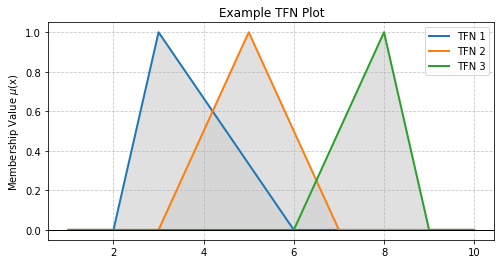

In [38]:
plt.rcParams['figure.figsize'] = (8, 4)
data = [[2, 3, 6], [3, 5, 7], [6, 8, 9]]
multiple_tfn_plot(data, title='Example TFN Plot')
plt.show()

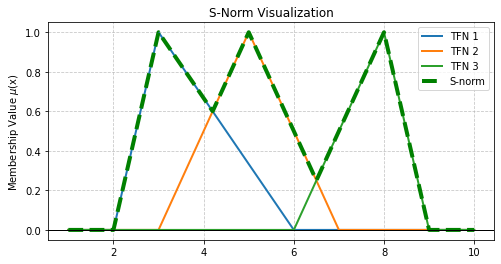

In [39]:
plt.rcParams['figure.figsize'] = (8, 4)
data = [[2, 3, 6], [3, 5, 7], [6, 8, 9]]
s_norm_tfn_plot(data, title='S-Norm Visualization')
plt.show()

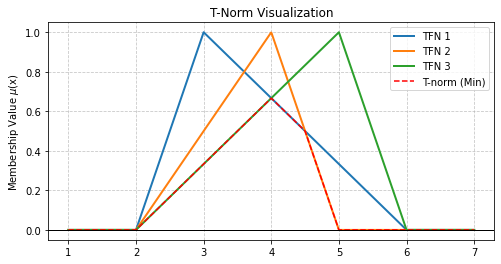

In [41]:
plt.rcParams['figure.figsize'] = (8, 4)
data = [[2, 3, 6], [2, 4, 5], [2, 5, 6]]
t_norm_tfn_plot(data, title='T-Norm Visualization')
plt.show()

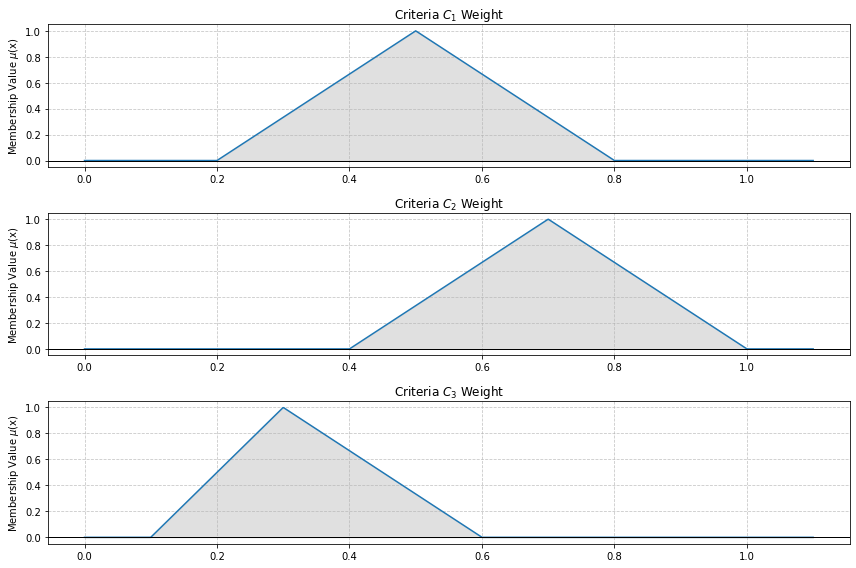

In [42]:
plt.rcParams['figure.figsize'] = (8, 4)
criteria = [[0.2, 0.5, 0.8], [0.4, 0.7, 1.0], [0.1, 0.3, 0.6]]
tfn_criteria_plot(criteria)
plt.show()